# In this Notebook

1. Latent Factor Models
    
2. Dimensionality Reduction and Neighbourhood Methods

3. SVD

4. The Vanilla Matrix Factorization Model

## 1. Latent Factor Models
</div>

Matrix factorization is a simple embedding model, which decomposes the user-item intraction matrix, $R \in \mathbb{R}^{m\times n}$ matrix, where $m$ is the number of users and $n$ the number of items, into the product of two lower dimensionality rectangular matrice. The the goal of the factorization models is to learn:
* A user embedding (or user latent factor) $P \in \mathbb{R}^{m\times k}$, where row $i$ is the embedding of user $i$.
* A item embedding (or item latent factor) $Q \in \mathbb{R}^{n\times k}$, where row $j$ is the embedding of user $j$.

![alt factorization models](https://miro.medium.com/max/988/1*nIVWl2ROaxOY23hHajkTTg.png)

$$ R = UV^T$$
$$ \hat{R} \approx  UV^T$$
$$ \hat{r}_{i,j} \approx  \hat{u}_i\cdot\hat{v}_j$$
$$\sum_{s=1}^{k}\text{(Affinity of user i to concept S)}\cdot\text{(Affinity of item j to concept S)}$$


These methods became really popular due to the shown efficiency in the Netflix Prize Challenge. 

There are several variants of these methods:
* SVD 
* Vanilla Factorization Matrix (also knwon as Funk SVD)
* Vanilla Factorization Matrix with biases 
* SVD++
* ...


In other words, the idea is to found topics as follows:
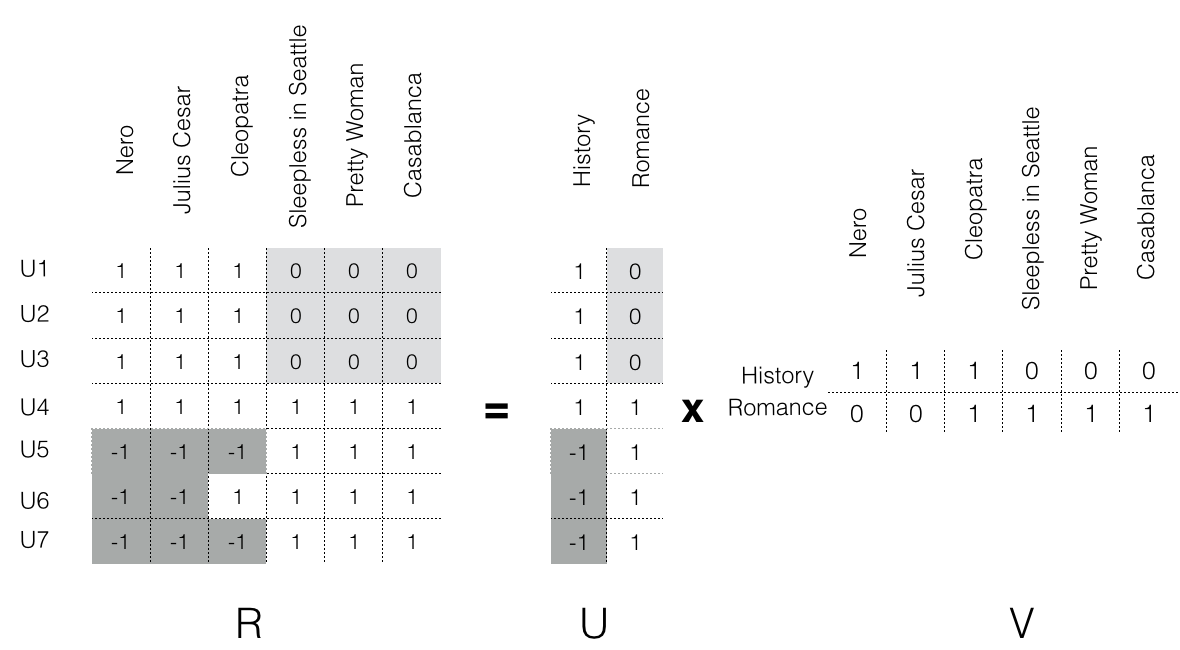

In [ ]:
def evaluate(predict_f,data_train,data_test):
    """ RMSE-based predictive performance evaluation with pandas. """
    ids_to_estimate = zip(data_test.user_id, data_test.movie_id)
    estimated = np.array([predict_f(u,i) if u in data_train.user_id else 3 for (u,i) in ids_to_estimate ])
    real = data_test.rating.values
    return compute_rmse(estimated, real)

def compute_rmse(y_pred, y_true):
    """ Compute Root Mean Squared Error. """
    return np.sqrt(np.mean(np.power(y_pred - y_true, 2)))


## Divide the data in two sets: training and test
def assign_to_set(df):
    sampled_ids = np.random.choice(df.index,
                                   size=np.int64(np.ceil(df.index.size * 0.2)),
                                   replace=False)
    df.loc[sampled_ids, 'for_testing'] = True
    return df

In [ ]:
%autosave 150
%matplotlib inline
import pandas as pd
import numpy as np
import math
import matplotlib.pylab as plt

# Load Data set
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('./ml-1m/users.dat', sep='::', names=u_cols, engine='python')

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', names=r_cols, engine='python')

# the movies file contains columns indicating the movie's genres
# let's only load the first three columns of the file with usecols
m_cols = ['movie_id', 'title', 'release_date']
movies = pd.read_csv('./ml-1m/movies.dat', sep='::', names=m_cols, usecols=range(3), encoding='latin-1', engine='python')

# Construcció del DataFrame
data = pd.merge(pd.merge(ratings, users), movies)
data = data[['user_id','title', 'movie_id','rating','release_date','sex','age']]


print("Full DB has "+ str(data.shape[0]) +" ratings")
print("Full DB has ", data.user_id.nunique()," users")
print("Full DB has ", data.movie_id.nunique(), " movies")
data.head()


## DIVIDE THE DATA INTO TRAINING AND TEST SET
data['for_testing'] = False
grouped = data.groupby('user_id', group_keys=False).apply(assign_to_set)
data_train = data[grouped.for_testing == False]
data_test = data[grouped.for_testing == True]


print("Training data_set has "+ str(data_train.shape[0]) +" ratings")
print("Test data set has "+ str(data_test.shape[0]) +" ratings")

## 2. Dimensionality Reduction and Neighbourhood Methods

Dimensionality reduction can improve neighborhood methods in terms of accuracy and also in terms of efficiency.


* A reduced representation of the data can be created in terms of either row-wise latent factors or column-wise latent factors. In other, words, the reduced representation will compress items or users into latent factors. 
* Can alleviate the sparsity problems for neigbborhood-based models.
* Depending on which represetations is compressed, it can be used as user-based or item-based neigborhood model.
* The latent representation can be also computed in <b>both</b> dimensions simultaneously. The full $m \times n$ matrix is obtained in one shot without the use of neigborhood-based methods.



In [ ]:
from sklearn.decomposition import TruncatedSVD
from scipy import sparse

class SVD_CollaborativeFiltering:
    """ Collaborative filtering using a custom sim(u,u'). """
    
    def __init__(self,DataFrame, num_components=10):
        """ Constructor """
        self.df=DataFrame
        self.num_components=num_components
        
    def fit(self):
        """ Prepare data structures for estimation. Similarity matrix for users """
        allUsers=set(self.df['user_id'])
        
        svd = TruncatedSVD(n_components=self.num_components)
        
        urm = pd.pivot_table(self.df[['user_id','movie_id','rating']],columns='movie_id',index='user_id',values='rating',fill_value=0)
        
        user_index = np.arange(len(urm.index))
        self.users = dict(zip(user_index,urm.index ))
        self.users_id2index = dict(zip(urm.index,user_index)) 
        
        movie_index = np.arange(len(urm.columns))
        self.movies_id2index= dict(zip(urm.columns, movie_index))
        self.movies_index2id= dict(zip(movie_index,urm.columns))
        
        X= np.float32(urm.values)
        
        
        #Lets continue.....
        matrix = svd.fit_transform(X)
        print(matrix.shape)
        self.sim = np.corrcoef(matrix)
    
    def predict(self, user_id, movie_id):
        movie_users = self.df[self.df['movie_id'] ==movie_id]
        #movie_users = movie_users.set_index('user_id')
                
        allUsers = [ self.users_id2index[user_index] for user_index in movie_users.user_id if user_index in self.users_id2index] 
        a = movie_users.rating.values
        b = self.sim[self.users_id2index[user_id]][allUsers] 
        rating_num = np.sum(a*b)
        rating_den = np.sum(b)
        if rating_den==0: 
            if self.df.rating[self.df['movie_id']==movie_id].mean()>0:
                # return the mean movie rating if there is no similar for the computation
                return self.df.rating[self.df['movie_id']==movie_id].mean()
            else:
                # else return mean user rating 
                return self.df.rating[self.df['user_id']==user_id].mean()
        return rating_num/rating_den


## 3. SVD
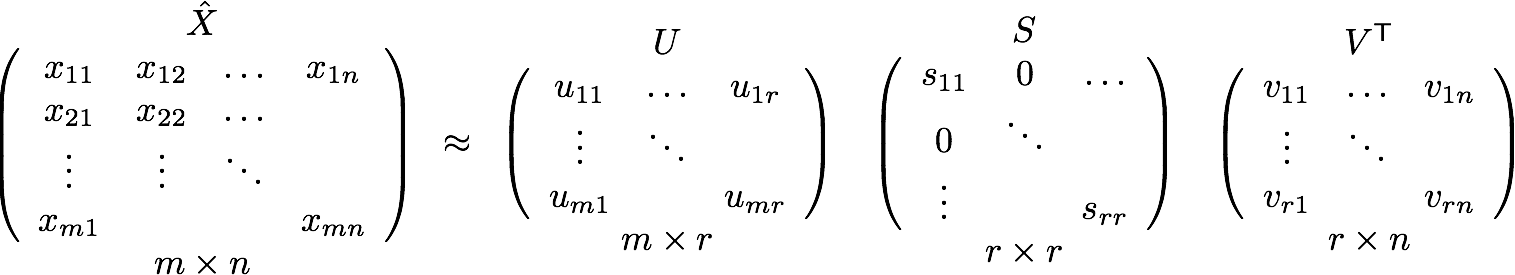
* Columns of U and V are constrained to be mutually orthogonal. 
* Mutual orthogonality has the advantage that the concepts can be completely independent of one another. Can be interpreted in scatterplots

In [ ]:
from scipy import sparse
from scipy.linalg import sqrtm

class RecSys_mf():
    """ Collaborative filtering using SVD. """
    
    def __init__(self,df, num_components=10):
        """ Constructor """
        self.num_components=num_components
        self.train = pd.pivot_table(df[['user_id','movie_id','rating']],columns='movie_id',index='user_id',values='rating')
        
        # We create a dictionary where we will store the user_id and movie_id which correspond 
        # to each index in the Rating matrix
        
        user_index = np.arange(len(self.train.index))
        self.users = dict(zip(user_index,self.train.index ))
        self.users_id2index = dict(zip(self.train.index,user_index)) 
        
        movie_index = np.arange(len(self.train.columns))
        self.movies = dict(zip(movie_index,self.train.columns )) 
        self.movies_id2index= dict(zip(self.train.columns, movie_index))
        self.movies_index2id= dict(zip(movie_index,self.train.columns))
        self.movie_id2title = dict(df.groupby(by=['movie_id','title']).count().index)
        
        
    def fit(self):
        """ We decompose the R matrix into to submatrices using the training data """
        train_matrix = np.array(self.train)
        # we mask those nan value to fill with the mean 
        mask = np.isnan(train_matrix)
        masked_arr = np.ma.masked_array(train_matrix, mask)
        item_means = np.mean(masked_arr, axis=0)

        # nan entries will replaced by the average rating for each item
        train_matrix = masked_arr.filled(item_means)
        x = np.tile(item_means, (train_matrix.shape[0],1))         

        # we remove the per item average from all entries.
        # the above mentioned nan entries will be essentially zero now
        train_matrix = train_matrix - x
        U, s, V = np.linalg.svd(train_matrix, full_matrices=False)

        # reconstruct rating matix
        S = np.diag(s[0:self.num_components])
        U = U[:,0:self.num_components]
        V = V[0:self.num_components,:]
        S_root = sqrtm(S)

        USk=np.dot(U,S_root)
        SkV=np.dot(S_root,V)
        Y_hat = np.dot(USk, SkV)
        self.Y_hat = Y_hat + x
        
    def predict(self, user_id, movie_id):
        
        if movie_id in self.movies_id2index:
            return self.Y_hat[self.users_id2index[user_id],self.movies_id2index[movie_id]]
        else: # in case it is a new movie 
            return 3

In [ ]:
reco = RecSys_mf(data_train,num_components=30)
reco.fit()
print('RMSE for Collaborative Recomender: %s' % evaluate(reco.predict,data_train,data_test))

Ok, but... what should we do with the huge amount of unknow values? 
* Traditionally, the average rating of the movies was used for all unkown items.

And, what happens if the number of users and item is large? 
* The factorization of the matrix becomes harder and the solution is not ensured to be the optimal. 

## 4. The Vanilla Matrix Factorization Model 
* Also know as **Funk SVD**
* * Despite its name, in Funk SVD, no singular value decomposition is applied.
* * https://sifter.org/simon/journal/20061211.html

A straightforward matrix factorization model maps both users and items to a joint latent factor space of dimensionality D. User-item interaction are modeled as inner products in that space
$$ \hat{R} = Q^TP$$

Each item j is associated with a vector $v_j$ from $V$, and each user $i$ is associated with a vecor $u_i$ from $U$.
The resulting dot product $u_i\cdot v_j$ captures the interaction between the user $i$ and item $j$:
$$ \hat{r}_{u,i} = q^T_ip_u$$

The goal of the matrix factorization consist on finding the mapping of each item and user to factors $u_i$ and $v_j$. To do so, the minimization the of squarred error function is performed:

$$ minimize_{Q,P} \sum_{u,i \in K} (r_{u,i} - q^t_ip_u )^2$$

To generalize well and not over-fit the training set, a penalty term is usually introduced into the minimization equation. This is represented by a regularization factor $\lambda$ multiplied by the square sum of the magnitudes of user and item vectors.

$$ minimize_{Q,P} \sum_{u,i \in K} (r_{u,i} - q^t_ip_u )^2 + \lambda(|| q_i||^2 + || p_u||^2)$$

This factorization can be learnt using **only those known ratings**. We do not need to infer missing values.

![alt Amazon](https://miro.medium.com/max/4800/1*b4M7o7W8bfRRxdMxtFoVBQ.png)

In [ ]:
from scipy import sparse

class RecSys_vanilla_mf(RecSys_mf):
    """ Collaborative filtering using a custom sim(u,u'). """

    def __sdg__(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            user_id = self.users[u]
            item_id = self.movies[i]
            
            prediction = self.predict(user_id, item_id)
            error = (self.ratings[u,i] - prediction) # error
            
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate * \
                                    (error * self.item_vecs[i, :] - \
                                     self.lmbda * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (error * self.user_vecs[u, :] - \
                                     self.lmbda * self.item_vecs[i,:])
                
                
    def fit(self,n_epochs = 10,learning_rate =0.001,lmbda=0.1,verbose =True):
        """ We decompose the R matrix into to submatrices using the training data """
        self.verbose = verbose
        self.learning_rate = learning_rate
        self.lmbda = lmbda
        
        self.ratings = np.float32(self.train.fillna(0).values)
        self.n_users, self.n_items = self.train.shape
        self.sample_row, self.sample_col = self.ratings.nonzero()
        self.n_samples = len(self.sample_row)
        
        self.train_rmse =[]
        self.test_rmse = []
        iter_diff = 0
        
        # initialize latent vectors
        self.user_vecs = 3.*np.random.normal(scale=1./self.num_components,\
                                          size=(self.n_users, self.num_components))
        self.item_vecs = 3.*np.random.normal(scale=1./self.num_components,
                                          size=(self.n_items, self.num_components))

        for epoch in range(n_epochs):
            print('Epoch: {}'.format(epoch))
            
            self.training_indices = np.arange(self.n_samples)
            
            #shuffle training samples
            np.random.shuffle(self.training_indices)
            self.__sdg__()
            
            self.train_rmse.append(evaluate(self.predict,data_train,data_train))
            self.test_rmse.append(evaluate(self.predict,data_train,data_test))
            
            
            print('\tTrain rmse: %s' % self.train_rmse[-1])
            print('\tTest rmse: %s' % self.test_rmse[-1])
            
        
        if(self.verbose):
            self.__plot_learning_curves__()
    
    def __plot_learning_curves__(self):
        plt.plot(self.train_rmse,'--o',label="train_error")
        plt.plot(self.test_rmse,'--o',label="test_error")
        plt.legend()
        plt.show()
        
    def predict(self, user_id, movie_id):
        """ Single user and item prediction."""
        user_index = self.users_id2index[user_id]
        if movie_id in self.movies_id2index:
            item_index = self.movies_id2index[movie_id]
            prediction =  self.user_vecs[user_index, :].dot(self.item_vecs[item_index, :].T)
        else:
            prediction = 3 # this is a new movie
        if(prediction>5): # clip the result
            return 5
        elif(prediction<1):
            return 1
        return prediction
    

In [ ]:
reco = RecSys_vanilla_mf(data_train,num_components=5)
reco.fit(n_epochs = 5,learning_rate=0.01,lmbda=0.5)
print('RMSE for Collaborative Recomender: %s' % evaluate(reco.predict,data_train,data_test))

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
movie_id = 1 #'Toy Story (1995)'
movie_id = 364 #'Lion King, The (1994)'

pairwise_distances = euclidean_distances(reco.item_vecs, reco.item_vecs)
[(reco.movie_id2title[reco.movies_index2id[item]],
  item) for item in np.argsort(pairwise_distances[reco.movies_id2index[movie_id]])[0:6]]

### The Vanilla Matrix Factorization Model with biases 

* Despite its name, in SVD++, no singular value decomposition is applied.


Now the model is defined as:
$\hat{r}_{ui} = \bar{r} + b_{u_u} + b_{i_i}  \sum_{k = 1}^KP_{uk} Q_{ik}^T  $

To learn the model we can use the SGD as before. Now the latent factors and biases are updated as follows:
* $error = r -\hat{r}$
* $b_{u_u} = b_{u_u} + \alpha*(error -  \lambda*b_{u_u})$
* $b_{i_i} = b_{i_i} + \alpha*(error -  \lambda*b_{i_i})$
* $P_{uk} = P_{uk} + \alpha*(error*Q_{ik} -  \lambda*P_{uk})$
* $Q_{ik} = Q_{ik} + \alpha*(error*P_{uk} -  \lambda*Q_{ik})$

where $\alpha$ is the learning rate and $\lambda$ is the regularization term.

In [ ]:
from scipy import sparse

class RecSys_vanilla_mf_biases(RecSys_vanilla_mf):
                  
    def __sdg__(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            user_id = self.users[u]
            item_id = self.movies[i]
            
            prediction = self.predict(user_id, item_id)
            error = (self.ratings[u,i] - prediction) # error
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate * \
                                    (error * self.item_vecs[i, :] - self.lmbda * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (error * self.user_vecs[u, :] - self.lmbda * self.item_vecs[i,:])
            
            self.bias_item[i] += self.learning_rate * (error - self.lmbda * self.bias_item[i]) 
            self.bias_user[u] += self.learning_rate * (error - self.lmbda * self.bias_user[u]) 
            
                
    def fit(self,n_epochs = 10,learning_rate =0.001,lmbda=0.1,verbose =True):
        """ Train the model. """
        self.verbose = verbose
        self.learning_rate = learning_rate
        self.lmbda = lmbda
        
        self.ratings = np.float32(self.train.fillna(0).values)
        self.mean_rating = self.ratings[self.ratings>0].mean() 
        self.n_users, self.n_items = self.train.shape
        self.sample_row, self.sample_col = self.ratings.nonzero()
        self.n_samples = len(self.sample_row)
        
        self.train_rmse =[]
        self.test_rmse = []
        iter_diff = 0
        
        # initialize latent vectors
        self.user_vecs = np.random.normal(scale=1./self.num_components,\
                                          size=(self.n_users, self.num_components))
        self.item_vecs = np.random.normal(scale=1./self.num_components,
                                          size=(self.n_items, self.num_components))
        self.bias_item = np.random.normal(scale=1/self.n_items,size=(self.n_items))
        self.bias_user = np.random.normal(scale=1/self.n_users,size=(self.n_users))
        
        
        for epoch in range(n_epochs):
    
            print('Epoch: {}'.format(epoch))
            
            self.training_indices = np.arange(self.n_samples)
            
            #shuffle training samples
            np.random.shuffle(self.training_indices)
            self.__sdg__()
            
            self.train_rmse.append(evaluate(reco.predict,data_train,data_train))
            self.test_rmse.append(evaluate(reco.predict,data_train,data_test))
            
            print('\tTrain rmse: %s' % self.train_rmse[-1])
            print('\tTest rmse: %s' % self.test_rmse[-1])
        
        if(self.verbose):
            self.__plot_learning_curves__()
    
    def predict(self, user_id, movie_id):
        """ Single user and item prediction."""
        user_index = self.users_id2index[user_id]
        if movie_id in self.movies_id2index:
            item_index = self.movies_id2index[movie_id]
            prediction =  self.mean_rating + self.user_vecs[user_index, :].dot(self.item_vecs[item_index, :].T) + self.bias_item[item_index] + self.bias_user[user_index]
        else:
            prediction = self.mean_rating # this is a new movie

        return prediction
    

In [ ]:
reco = RecSys_vanilla_mf_biases(data_train,num_components=5)
reco.fit(n_epochs = 5,learning_rate=0.02)
print('RMSE for Collaborative Recomender: %s' % evaluate(reco.predict,data_train,data_test))

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
movie_id = 1 #'Toy Story (1995)'
#movie_id = 364 #'Lion King, The (1994)'

pairwise_distances = euclidean_distances(reco.item_vecs, reco.item_vecs)
[(reco.movie_id2title[reco.movies_index2id[item]],
  item) for item in np.argsort(pairwise_distances[reco.movies_id2index[movie_id]])[0:6]]

In [ ]:
reco = RecSys_vanilla_mf_biases(data_train,num_components=100)
reco.fit(n_epochs = 50,learning_rate=0.02,lmbda=0.1)

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
movie_id = 1 #'Toy Story (1995)'
#movie_id = 364 #'Lion King, The (1994)'

pairwise_distances = euclidean_distances(reco.item_vecs, reco.item_vecs)
[(reco.movie_id2title[reco.movies_index2id[item]],
  item) for item in np.argsort(pairwise_distances[reco.movies_id2index[movie_id]])[0:6]]

# Let's think about the problem! 
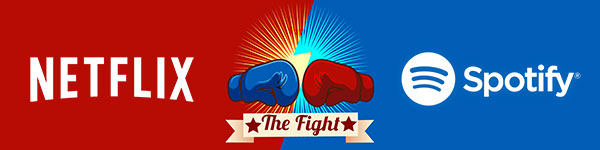

In [ ]:
# What do you think?

### Important Challenges on Recommender Music:
* Cold Start Problem
 * Really sparse problem
 * Cross domain techniques
* Automatic PlayList Generation
 * Contextual features are really important: from time, mode or location to weather
* Evaluation
 * How do we know that was a good track for the user?

### RecSys 2018
Interesting Challenge on Recommender Systms:
http://www.recsyschallenge.com/2018/

This challenge, in collaboration with Spotify, focuses on music recommendation, specifically the challenge of automatic playlist continuation. By suggesting appropriate songs to add to a playlist, a Recommender System can increase user engagement by making playlist creation easier, as well as extending listening beyond the end of existing playlists.

Spotify have released a public dataset of playlists, consisting of a large number of playlist titles and associated track listings. For the evaluation purpose, there is a set of playlists from which a number of tracks have been withheld. The task will be to predict the missing tracks in those playlists.


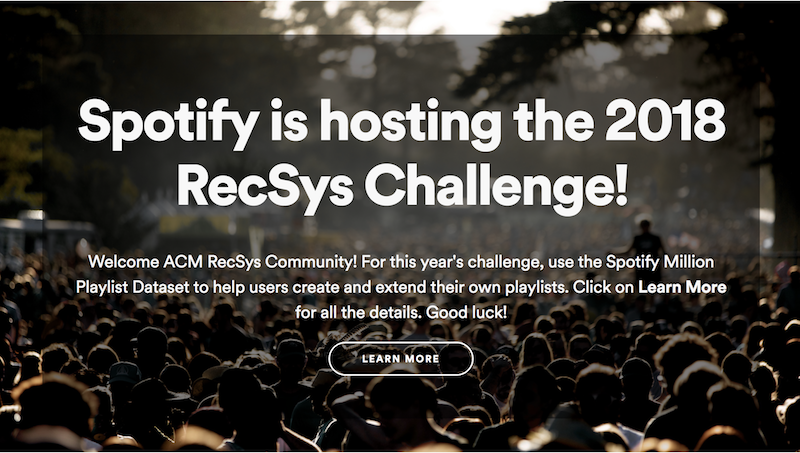

<h3>Evaluating Recommender systems</h3>
</div>


Can we evaluate if  our recommender is <b>good</b>?

If we look at this image: 
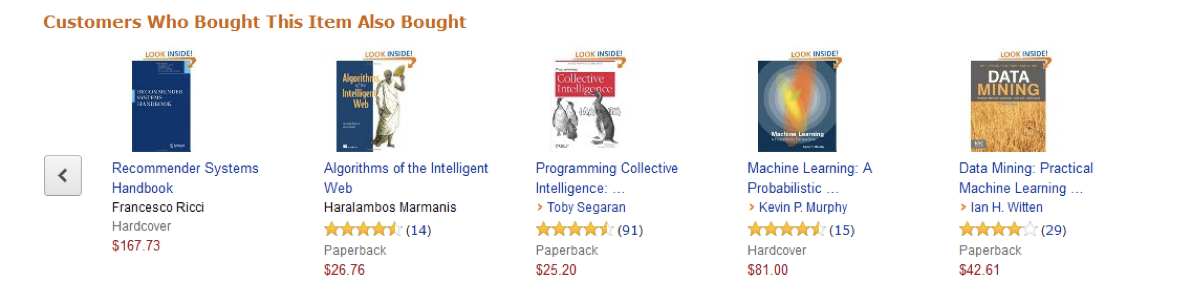
One may end with the following questions:

1st Question: <b> Which prodcuts should be in this list?</b>

2nd Question: <b> How do we know that these are good recommendations?</b>

3rd Question: <b> Good in terms of what</b>
* Data Scientist vs. Marketing vs. Economist


What does <b>Good</b> means??
 * Recommendation accuracy?
 * Recommendation quality?
 * System usability?
 * System  satisfaction?
 



##### There is three main ways to evaluate a Recommender Systems
The evaluation of the recommender systems is one the <b>most critical</b> steps when building a recommender system.
* A single criterion cannot capture many goals of the designer.

1) Offline Evaluation
 + Historical, such as ratings, are used. 
 + In some cases, temporal information is also provided with the ratings, such as the time-stamp at which the information was obtained.

2) User Studies
 + Test subjects are actively recruited, and asked to interact
 + with the recommendation system to perform some actions. Example: satisfaction questionaries


3) Online Evaluation
 + Online evaluation also leverage user studies except that users are real users of fully developed  or commercial  system. 
 + The user directly plays with the system,  usually different methods are compared with different random uses
 
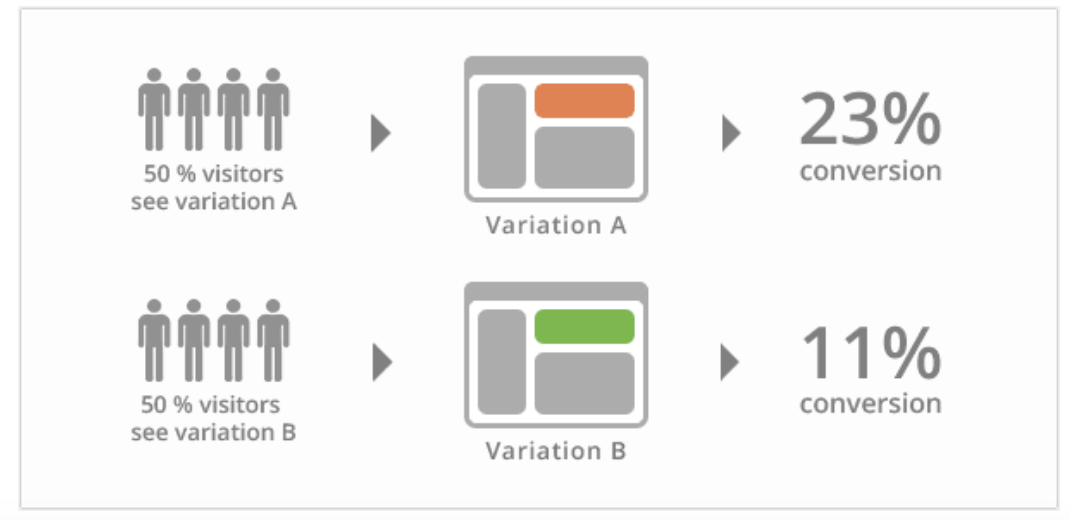

There exist several ways to evaluate a recommender system. Ones of the most populars are RMSE and MAE. However, <b>these metrics do not really measure the user experience</b>. 

Top-N performance metric can be also used and in fact, the evaluation with this metric is more closer to what is important for the user, just those top recommendations.


**EXERCISE:**
<p>
Create a new method in the recommendetion class that returns the TOP N recomendations for a user.</div>

In [ ]:
def getTopMovies(reco,user_id,N = 10):
    # Returns the N best (and not seen) movies for the user_id. 
    return 0

### How to compute the precision-recall?
We can use the strategy followed by P. Cremonesi et.al. in http://dl.acm.org/citation.cfm?id=1864721 <br>
In order to measure the precision recall, first the models is trained using the training data, and then, for each item $i$ rated with 5 stars in the test data set:
* A set of 100 random unseen movies for the user of the item $i$ are seleted. We assume that these random movies will not be at the same interest than the 5 star movie
* We predict the rating of the movie of item $i$ and 100 random unseen movies.
* We form a rank list by ordering all the 101 item according to the predicted rating. Let denote $p$ the rank of the test item $i$ within the list. The best results correspondes to the case the test item $i$ precedes all the random items (i.e., p=1).
* A top-N recommendation list by piking the N top ranked items from the list. If $p \leq N$ we have a hit. Otherwise we have a miss. Chanches of hit incresases as N is higher.




**EXERCISE:**<p>
Create a new method for the evaluation of the precision/recall curve using Top-N recomendations output.</div>

In [ ]:
def evaluateTop(estimate_f,data_train,data_test, N = 10):
    """ Precision-Recall evaluation bas on top Recommendations """
    return np.zeros((N,1)),np.zeros((N,1))

In [ ]:
precision,recall = evaluateTop(reco.predict,data_train,data_test,N=10)

In [ ]:
plt.plot( range(0,len(recall)),recall)
plt.xlabel('N')
plt.ylabel('recall')
plt.show()
plt.plot(recall, precision)
plt.ylabel('precision')
plt.xlabel('recall')
plt.show()


## 5. Other Popular Methods
</div>

### Restricted Boltzmann Machines for Collaborative Filtering  (2007)
http://www.cs.toronto.edu/~fritz/absps/netflix.pdf

### Method: SLIM - Sparse Linear Methods for Tope-N recommender systems (2011)

Computes the item-item relations, by estimating an $item \times item$ sparse aggregation coefficient matrix R.
The recommendation score of an unrated item $i$ for a user $u$ is:
$$ \hat{r}_{u,i} = r^T_u s_i$$
and the minimization problem is defined as:
$$\underset{S}{\text{minimize}} \frac{1}{2} \sum_{u,i}(r_{u,i} - \hat{r}_{u,i}^2) + \frac{\beta}{2}||S||^2_F  + \lambda||S||_1$$
$$ \text{subject to  }  R\geq 0, \text{and } Diag(S) = 0$$
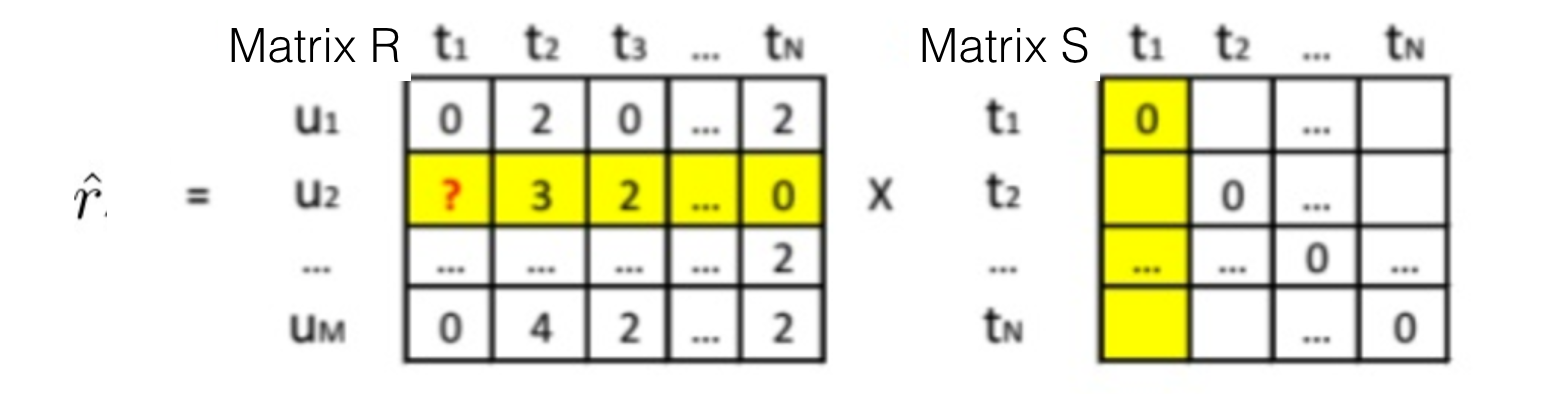

http://ieeexplore.ieee.org/document/6137254/ 


### Factorization Machines  (2010)

$$\hat{r}_{ui} = w_0+\sum_{j=1}^Nw_jx_j + \sum_{j=1}\sum_{k=k+1}x_jx_k<v_jv_k>$$
* Offers combination of regression and factorization models
* Low rank approximation ranking enables estimation of unobserved interactions
* Effective for sparse and extremely sparse data sets
* Flexible through feature engineering


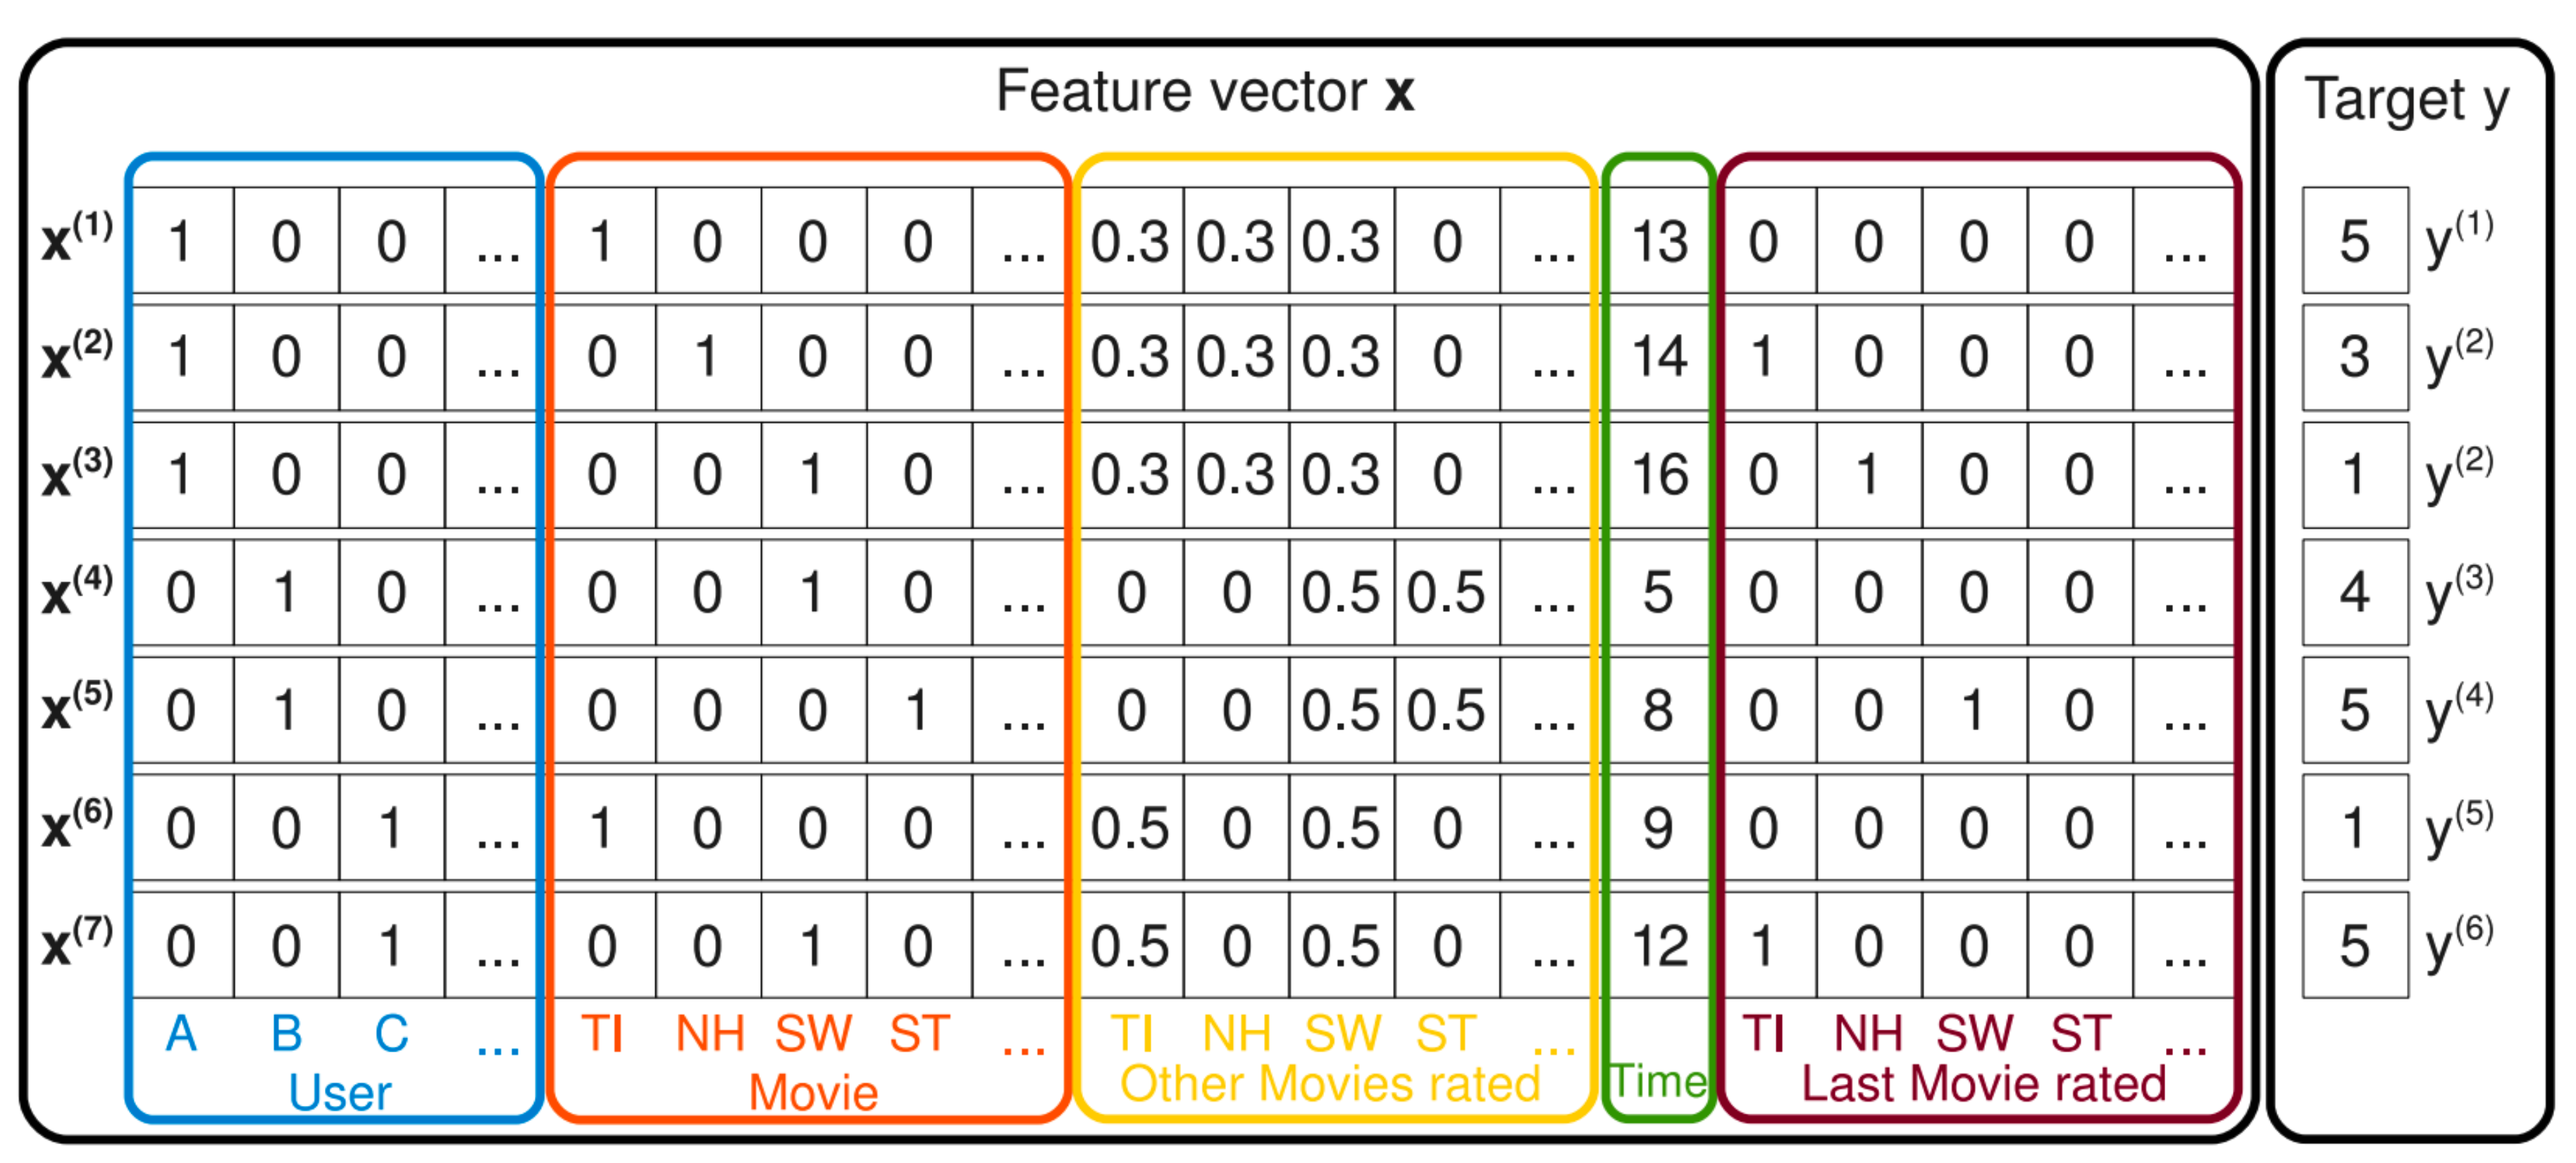
https://ieeexplore.ieee.org/document/5694074